Deep Learning Assignment 2 Pujan

code reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm


In [2]:

def get_device():
    return torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# print("Device is ",get_device())

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def get_output_width(input_width, filter_size, padding, stride):
    return ((input_width - filter_size + 2 * padding)/stride) + 1

print(get_output_width(input_width = 32, filter_size = 5, padding = 0, stride = 1))


28.0


In [3]:

class NetworkBase(nn.Module):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size = 32):
        super().__init__()
        torch.manual_seed(5)
        self.train_results = []
        self.epoch_number = 0
        self.print_interim_data_shapes = False
    
        transform = transforms.Compose(
            [
                #transforms.Grayscale(num_output_channels=3), # with grayscale, overfitting slightly decreased, this should be the result of data augmentation, this is not converting all images to grayscale
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

        if data_set_name == "cifar_10":
            dataset = torchvision.datasets.CIFAR10(root=download_path, train=True, download=True, transform=transform)
            print('Length of Dataset ', len(dataset))

            train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_data_size, validation_data_size])
            print('Length of Train set ', len(train_dataset))
            print('Length of Val set ', len(val_dataset))
            self.trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
            self.valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

            testset = torchvision.datasets.CIFAR10(root=download_path, train=False, download=True, transform=transform)
            print('Length of Testset ', len(testset))
            self.testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

            self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        
    def display_input_images(self, number_of_images):
        # get some random training images
        dataiter = iter(self.trainloader)
        images, labels = dataiter.next()

        # show images
        imshow(torchvision.utils.make_grid(images))
        # print labels
        print(' '.join(f'{self.classes[labels[j]]:5s}' for j in range(number_of_images)))

    def display_ground_truth_images(self, number_of_images):
        dataiter = iter(self.testloader)
        images, labels = dataiter.next()

        # print images
        imshow(torchvision.utils.make_grid(images))
        print('GroundTruth: ', ' '.join(f'{self.classes[labels[j]]:5s}' for j in range(4)))


    def train(self, epoch_number, learning_rate, momentum, optimizer_name):
        optimizer = optim.SGD(self.parameters(), lr= learning_rate, momentum=momentum)
        # if optimizer_name == "sgd": 
        self.epoch_number = epoch_number
        train_results = []

        for epoch in range(epoch_number):  # loop over the dataset multiple times
            # Training phase
            for i, train_data in enumerate(self.trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                train_inputs, train_labels = train_data[0].to(get_device()), train_data[1].to(get_device())
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                train_outputs = self(train_inputs)
                train_loss = self.criterion(train_outputs, train_labels)
                train_loss.backward()
                optimizer.step()
                
            train_accuracy, train_loss_value = self.get_accuracy_and_loss(self.trainloader)

            val_accuracy, val_loss_value = self.get_accuracy_and_loss(self.valloader)

            train_result = {'epoch': epoch, 'train_loss': train_loss_value, 'train_accuracy': train_accuracy, 
                                  'val_loss': val_loss_value, 'val_accuracy': val_accuracy}
            print('Train result ', train_result)
            train_results.append(train_result)

        print('Finished Training')
        self.train_results = train_results
        return train_results

    def plot_loss_and_accuracy_curves(self):
        epoch_numbers = range(self.epoch_number)
        # loss curves : train / val
        # accuracy curves: train / val
 
        # accuracy curve    
        train_accuracies = [x['train_accuracy'] for x in self.train_results]
        val_accuracies = [x['val_accuracy'] for x in self.train_results]    
        plt.plot(train_accuracies, label="train")
        plt.plot(val_accuracies, label="val")
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title("Accuracy vs Epoch")
        plt.show()

        # Loss curve    
        train_losses = [x['train_loss'] for x in self.train_results]
        val_losses = [x['val_loss'] for x in self.train_results]    
        plt.plot(train_losses, label="train")
        plt.plot(val_losses, label="val")
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title("Loss vs Epoch")
        plt.show()

    def predictions(self, input_images):
        outputs = self(input_images)
        _, predicted = torch.max(outputs, 1)
        print('Predicted: ', ' '.join(f'{self.classes[predicted[j]]:5s}' for j in range(4)))

    def get_accuracy_score(self, outputs, labels):
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        return correct

    def get_accuracy_and_loss(self, data_loader):
        accuracies = []
        loss_values = []
        total_label_size = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in data_loader:
                # images, labels = data
                images, labels = data[0].to(get_device()), data[1].to(get_device())
                # calculate outputs by running images through the network
                outputs = self(images)
                # the class with the highest energy is what we choose as prediction
                # TODO: find top-k accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_label_size += labels.size(0)
                accuracy_item = (predicted == labels).sum().item()
                accuracies.append(accuracy_item)

                # losses
                loss = self.criterion(outputs, labels)
                loss_item = loss.item()
                loss_values.append(loss_item)
        
        accuracy_score = 100 * np.sum(accuracies) / total_label_size
        loss_value = np.mean(loss_values)
        return (accuracy_score, loss_value)

    def accuracy_in_each_class(self):
    # prepare to count predictions for each class
        correct_pred = {classname: 0 for classname in self.classes}
        total_pred = {classname: 0 for classname in self.classes}

        # again no gradients needed
        with torch.no_grad():
            for data in self.testloader:
                # images, labels = data
                images, labels = data[0].to(get_device()), data[1].to(get_device())
                outputs = self(images)
                _, predictions = torch.max(outputs, 1)
                # collect the correct predictions for each class
                for label, prediction in zip(labels, predictions):
                    if label == prediction:
                        correct_pred[self.classes[label]] += 1
                    total_pred[self.classes[label]] += 1

        # print accuracy for each class
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    




In [ ]:
class CnnNetwork(NetworkBase):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion):
        super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion)
        self.criterion = criterion
        # input channel should be 3 for color image and 1 for grayscale
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        # https://discuss.pytorch.org/t/example-on-how-to-use-batch-norm/216
        self.conv1_bn = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn = nn.BatchNorm2d(16)
        # mat1 and mat2 shapes cannot be multiplied (4x576 and 400x120)
        # filter = 1, input shape for linear should be 6 * 6,
        # filter = 3, 5, input shape for linear should be 5 * 5
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.softmax = nn.Softmax(1)
        self.dropout_2d = nn.Dropout2d()
        self.dropout_1d = nn.Dropout1d()

    def forward(self, x):
        if self.print_interim_data_shapes:
            print("Initial x shape ", x.shape)
        # x = self.pool(F.relu(self.conv1(x)))
        # print("After conv1 and maxpool, x shape ", x.shape)

        # First layer
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = F.relu(x)
        if self.print_interim_data_shapes:
            print('After conv1, shape of x is ', x.shape)
        x = self.pool(x)
        if self.print_interim_data_shapes:
            print('After max pool 1, shape of x is ', x.shape)
        
        # dropout
        # x = self.dropout_2d(x)
        if self.print_interim_data_shapes:
            print('Shape after dropout after conv layer 1 ', x.shape) 
        # Second layer
        # x = self.pool(F.relu(self.conv2(x)))
        # print("After conv2 and maxpool, x shape ", x.shape)

        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = F.relu(x)
        if self.print_interim_data_shapes:
            print('After conv2, shape of X is ', x.shape)
        x = self.pool(x)
        if self.print_interim_data_shapes:
            print('After max pool 2, shape of x is ', x.shape)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        if self.print_interim_data_shapes:
            print('After flatten, x shape ', x.shape)

        x = self.fc1(x)
        x = self.fc1_bn(x)
        x = F.relu(x)
        if self.print_interim_data_shapes:
            print('After fc1, x shape ', x.shape)

        x = self.fc2(x)
        x = F.relu(x)
        if self.print_interim_data_shapes:
            print('After fc2, x shape ', x.shape)
        x = self.fc3(x)
        if self.print_interim_data_shapes:
            print('After fc3, x shape ', x.shape)
            break_here_i_want_to_see_shapes
        x = self.softmax(x)
        return x



Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Train result  {'epoch': 0, 'train_loss': 2.262654469680786, 'train_accuracy': 19.835, 'val_loss': 2.2629527063034596, 'val_accuracy': 20.29}
Train result  {'epoch': 1, 'train_loss': 2.2113254102706907, 'train_accuracy': 25.91, 'val_loss': 2.2110502757965187, 'val_accuracy': 26.02}
Finished Training


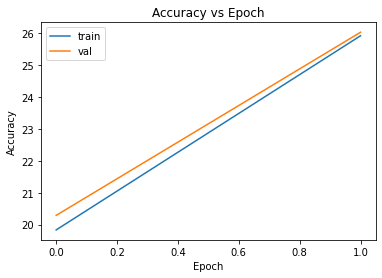

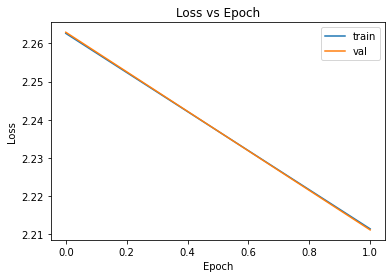

Test Accuracy  26.54
Test Loss  2.212437265597212


In [ ]:

criterion = nn.CrossEntropyLoss()

cnn_network = CnnNetwork(data_set_name = "cifar_10", batch_size = 32, download_path = "./data", 
                     train_data_size = 40000, validation_data_size = 10000, criterion = criterion)
cnn_network = cnn_network.to(get_device())

train_results = cnn_network.train(epoch_number = 2, learning_rate = 0.001, momentum = 0.9, optimizer_name = "sgd")
cnn_network.plot_loss_and_accuracy_curves()
# print(train_results)
test_accuracy, test_loss = cnn_network.get_accuracy_and_loss(cnn_network.testloader)
print('Test Accuracy ', test_accuracy)
print('Test Loss ', test_loss)

In [ ]:
from torchvision import models
alexnet = models.alexnet(pretrained=True)
print(alexnet)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Num feat  1280
Train result  {'epoch': 0, 'train_loss': 2.5912903977274895, 'train_accuracy': 10.9, 'val_loss': 2.597988726758957, 'val_accuracy': 11.44}
Train result  {'epoch': 1, 'train_loss': 2.495763815867901, 'train_accuracy': 13.83, 'val_loss': 2.480196258020401, 'val_accuracy': 13.81}
Finished Training


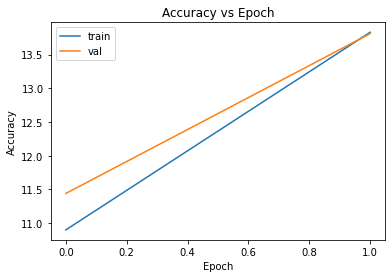

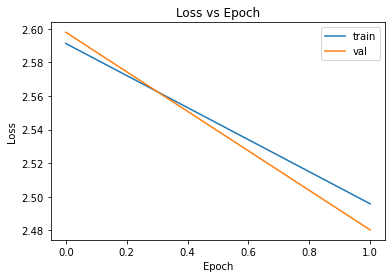

Test Accuracy  13.7
Test Loss  2.4903084722042084


In [ ]:
class CnnMobileNet(NetworkBase):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion):
        super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion)
        self.network = models.mobilenet_v2(pretrained=True)
        num = 1
        num_ftrs = self.network.classifier[num].in_features
        print('Num feat ',num_ftrs)
        self.network.classifier[num]= torch.nn.Linear(num_ftrs,10)
        self.criterion = criterion

    def forward(self, x):
        return self.network(x) 

criterion = nn.CrossEntropyLoss()

cnn_network = CnnMobileNet(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                     train_data_size = 40000, validation_data_size = 10000, criterion = criterion)
cnn_network = cnn_network.to(get_device())

train_results = cnn_network.train(epoch_number = 2, learning_rate = 0.001, momentum = 0.9, optimizer_name = "sgd")
cnn_network.plot_loss_and_accuracy_curves()
# print(train_results)
test_accuracy, test_loss = cnn_network.get_accuracy_and_loss(cnn_network.testloader)
print('Test Accuracy ', test_accuracy)
print('Test Loss ', test_loss)

In [ ]:
class CnnMobileNet(NetworkBase):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion):
        super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion)
        self.network = models.mobilenet_v2(pretrained=False)
        num = 1
        num_ftrs = self.network.classifier[num].in_features
        print('Num feat ',num_ftrs)
        self.network.classifier[num]= torch.nn.Linear(num_ftrs,10)
        self.criterion = criterion

    def forward(self, x):
        return self.network(x) 

criterion = nn.CrossEntropyLoss()

cnn_network = CnnMobileNet(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                     train_data_size = 40000, validation_data_size = 10000, criterion = criterion)
cnn_network = cnn_network.to(get_device())

train_results = cnn_network.train(epoch_number = 2, learning_rate = 0.001, momentum = 0.9, optimizer_name = "sgd")
cnn_network.plot_loss_and_accuracy_curves()
# print(train_results)
test_accuracy, test_loss = cnn_network.get_accuracy_and_loss(cnn_network.testloader)
print('Test Accuracy ', test_accuracy)
print('Test Loss ', test_loss)

Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Num feat  4096
Train result  {'epoch': 0, 'train_loss': 0.5405358301741245, 'train_accuracy': 81.48, 'val_loss': 0.641743822441576, 'val_accuracy': 78.6}
Train result  {'epoch': 1, 'train_loss': 0.4539467393615989, 'train_accuracy': 84.47, 'val_loss': 0.6062247447289526, 'val_accuracy': 79.48}
Finished Training


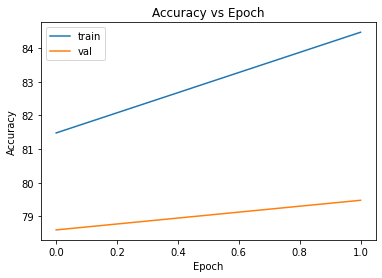

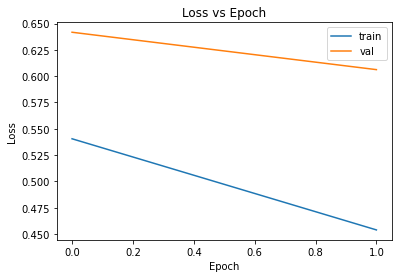

Test Accuracy  79.25
Test Loss  0.6103783772512074


In [ ]:
class CnnAlexNet(NetworkBase):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion):
        super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size=224)
        self.network = models.alexnet(pretrained=True)
        num = 6
        num_ftrs = self.network.classifier[num].in_features
        print('Num feat ',num_ftrs)
        # self.network.classifier[4]= torch.nn.Linear(4096,512)
        self.network.classifier[6]= torch.nn.Linear(num_ftrs,10)
        # (6): Linear(in_features=4096, out_features=1000, bias=True)
        self.criterion = criterion

    def forward(self, x):
        return self.network(x) 

criterion = nn.CrossEntropyLoss()

cnn_network = CnnAlexNet(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                     train_data_size = 40000, validation_data_size = 10000, criterion = criterion)
cnn_network = cnn_network.to(get_device())

train_results = cnn_network.train(epoch_number = 2, learning_rate = 0.001, momentum = 0.9, optimizer_name = "sgd")
cnn_network.plot_loss_and_accuracy_curves()
# print(train_results)
test_accuracy, test_loss = cnn_network.get_accuracy_and_loss(cnn_network.testloader)
print('Test Accuracy ', test_accuracy)
print('Test Loss ', test_loss)

In [4]:
from torchvision import models
resnet = models.resnet18(pretrained=True)
print(resnet)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Num feat  512
Train result  {'epoch': 0, 'train_loss': 0.5196386455833854, 'train_accuracy': 83.33, 'val_loss': 0.5934028921429068, 'val_accuracy': 81.35}
Train result  {'epoch': 1, 'train_loss': 0.2950286936472519, 'train_accuracy': 90.81, 'val_loss': 0.4232159459220711, 'val_accuracy': 86.57}
Finished Training


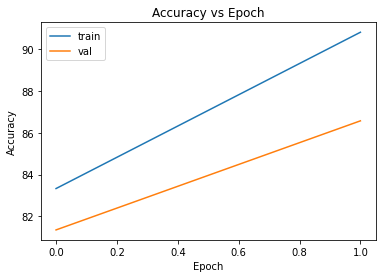

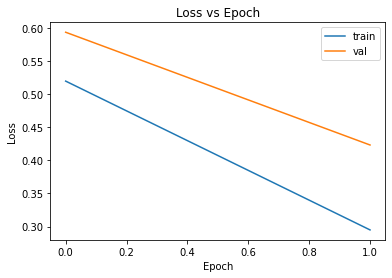

Test Accuracy  86.58
Test Loss  0.43041964543578215


In [5]:
class CnnResNet18(NetworkBase):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion):
        super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size=224)
        self.network = models.resnet18(pretrained=True)
        # num = 6
        num_ftrs = self.network.fc.in_features
        print('Num feat ',num_ftrs)
        # self.network.classifier[4]= torch.nn.Linear(4096,512)
        self.network.fc= torch.nn.Linear(num_ftrs,10)
        # (6): Linear(in_features=4096, out_features=1000, bias=True)
        self.criterion = criterion

    def forward(self, x):
        return self.network(x) 

criterion = nn.CrossEntropyLoss()

cnn_network = CnnResNet18(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                     train_data_size = 40000, validation_data_size = 10000, criterion = criterion)
cnn_network = cnn_network.to(get_device())

train_results = cnn_network.train(epoch_number = 2, learning_rate = 0.001, momentum = 0.9, optimizer_name = "sgd")
cnn_network.plot_loss_and_accuracy_curves()
# print(train_results)
test_accuracy, test_loss = cnn_network.get_accuracy_and_loss(cnn_network.testloader)
print('Test Accuracy ', test_accuracy)
print('Test Loss ', test_loss)

In [6]:
from torchvision import models
resnet = models.resnet101(pretrained=True)
print(resnet)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Files already downloaded and verified
Length of Dataset  50000
Length of Train set  40000
Length of Val set  10000
Files already downloaded and verified
Length of Testset  10000
Num feat  2048
Train result  {'epoch': 0, 'train_loss': 0.3867209702985128, 'train_accuracy': 87.7775, 'val_loss': 0.4598321797897108, 'val_accuracy': 84.73}
Train result  {'epoch': 1, 'train_loss': 0.22858824600867228, 'train_accuracy': 92.46, 'val_loss': 0.34253548673492623, 'val_accuracy': 89.03}
Finished Training


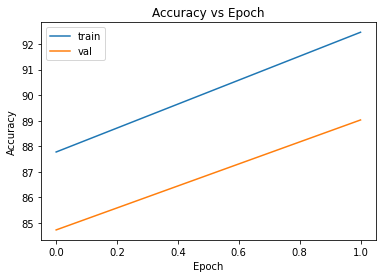

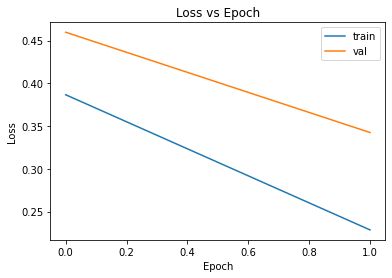

Test Accuracy  88.95
Test Loss  0.3430656472239236


In [7]:
class CnnResNet101(NetworkBase):
    def __init__(self, data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion):
        super().__init__(data_set_name, batch_size, download_path, train_data_size, validation_data_size, criterion, image_size=224)
        self.network = models.resnet101(pretrained=True)
        # num = 6
        num_ftrs = self.network.fc.in_features
        print('Num feat ',num_ftrs)
        # self.network.classifier[4]= torch.nn.Linear(4096,512)
        self.network.fc= torch.nn.Linear(num_ftrs,10)
        # (6): Linear(in_features=4096, out_features=1000, bias=True)
        self.criterion = criterion

    def forward(self, x):
        return self.network(x) 

criterion = nn.CrossEntropyLoss()

cnn_network = CnnResNet101(data_set_name = "cifar_10", batch_size = 4, download_path = "./data", 
                     train_data_size = 40000, validation_data_size = 10000, criterion = criterion)
cnn_network = cnn_network.to(get_device())

train_results = cnn_network.train(epoch_number = 2, learning_rate = 0.001, momentum = 0.9, optimizer_name = "sgd")
cnn_network.plot_loss_and_accuracy_curves()
# print(train_results)
test_accuracy, test_loss = cnn_network.get_accuracy_and_loss(cnn_network.testloader)
print('Test Accuracy ', test_accuracy)
print('Test Loss ', test_loss)

In [ ]:
# Experiments
# Pre processing: Convert into grayscale, since our objective is classification, we don't need  color too,
# try with grayscale image
# Post processing: pooling: Max pooling, average pooling, min pooling. But, practically, max pooling was found to be better by many researchers


# selecting the model
# CNN Architectures (How to choose CNN architecture ????) #Ans: intuitive
#   Number of Layers ??
# Batch Normalization : CNN, FC
# Dropout: for small network, the accuracy decreased, not so good

# Standard Architectures: AlexNet, GoogleNet, VGGNet, ResNet,  MobileNet..
# AlexNet, ResNet..
# Input data enhancements
# Data augmentation

# Hyper parameters
# Loss
# Optimizer
# Learning rate
# Batch size
# Epoch

# even if input size changes, it impacts performance, accuracy

# check what model.train and model.eval does in pytorch
# check reduceLROnPlateau
# FLOP counts : operations count
# use pretrained

# get time required to train for every experiment
